In [1189]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [1211]:
IN_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWithClustNums.tsv"
df = pd.read_csv(IN_PATH, sep="\t")

<ipython-input-1211-c2e4cd69b53a>:2: DtypeWarning: Columns (2,3,10,11,13,14,17,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(IN_PATH, sep="\t")


In [1212]:
df["date"] = pd.to_datetime(df["date"])
df = df.dropna(subset=["date"])

keep only data that overlaps with the local data we have (in time series) 

In [1213]:
articlesReported = df[["source", "key"]].groupby("source").agg(len).rename(columns={"key":"articlesReported"})
df = pd.merge(df, articlesReported, on="source", how="left")

In [1215]:
firstLocDate = min(df.loc[df["national"] == False, "date"])

clusteredDates = df[["clustNum", "date"]].groupby(by="clustNum").agg(list).reset_index()

clusteredDates["minDate"] = clusteredDates["date"].apply(lambda x: max(x))

#we can only keep clusters whose first article occured after the 
#first day of local coverage in our data, 4/1
keepClusts = clusteredDates.loc[clusteredDates["minDate"] >= firstLocDate, "clustNum"]

df = df[df["clustNum"].isin(keepClusts)]
len(df)

1178397

In [1216]:
df.columns

Index(['Unnamed: 0', 'key', 'local_id', 'sourcedomain_id', 'date', 'title',
       'content', 'url', 'fips', 'source', 'description', 'onlinesince',
       'rank', 'state', 'city', 'lon', 'lat', 'county', 'total_population',
       'white_pct', 'black_pct', 'hispanic_pct', 'nonwhite_pct',
       'foreignborn_pct', 'female_pct', 'age29andunder_pct',
       'age65andolder_pct', 'median_hh_inc', 'clf_unemploy_pct', 'lesshs_pct',
       'lesscollege_pct', 'lesshs_whites_pct', 'lesscollege_whites_pct',
       'rural_pct', 'ruralurban_cc', 'predrt_0', 'predrt_12', 'predrt_3',
       'national', 'id', 'author', 'published', 'published_utc',
       'collection_utc', 'year', 'clustNum', 'articlesReported'],
      dtype='object')

In [1217]:
clustDf = df[["clustNum", "source", "key", "title", "date", "state", "national", "median_hh_inc", "rural_pct", "total_population", "articlesReported"]].groupby("clustNum").agg(list)

clustDf["clustSize"] = clustDf["key"].apply(len)

In [1218]:
clustDf = clustDf[clustDf["clustSize"] < 3000]

In [1219]:
len(clustDf)

181905

In [1220]:
clustDf["duration"] = ((clustDf["date"].apply(max) - clustDf["date"].apply(min)) / np.timedelta64(1, "D")) + 1

In [1221]:
def firstDayPercent(inList): 
    dayOne = min(inList)
    return np.mean([day == dayOne for day in inList if day])

clustDf["dayOnePercent"] = clustDf["date"].apply(firstDayPercent)

(array([153113.,   8268.,   5636.,   3867.,   3460.,   2443.,   1963.,
          1386.,   1005.,    764.]),
 array([  1. ,  37.5,  74. , 110.5, 147. , 183.5, 220. , 256.5, 293. ,
        329.5, 366. ]),
 <BarContainer object of 10 artists>)

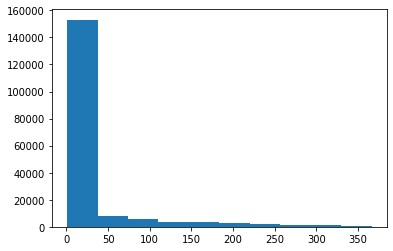

In [1222]:
plt.hist(clustDf["duration"])

In [1223]:
len(clustDf[clustDf["duration"] == 1]) / len(clustDf)

0.37726285698578926

In [1224]:
for currCutoff in [1, 10, 20, 30, 50]: 
    print(currCutoff)
    print(len(clustDf[clustDf["duration"] <= currCutoff]) / len(clustDf))

1
0.37726285698578926
10
0.7539924685962452
20
0.7990874357494296
30
0.8275253566422034
50
0.8614386630383991


## Most clusters are shortish

Text(0.5, 0, 'Cluster Duration')

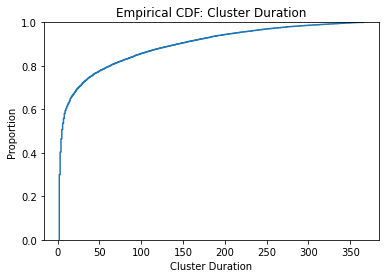

In [1225]:
over1 = clustDf[(clustDf["duration"] >= 2)]
sns.ecdfplot(x="duration", data=over1)
plt.title("Empirical CDF: Cluster Duration")
plt.xlabel("Cluster Duration")

In [1226]:
for currCutoff in [1, 10, 20, 30, 50]: 
    print(currCutoff)
    print(len(over1[over1["duration"] <= currCutoff]) / len(over1))

1
0.0
10
0.6049576708833941
20
0.6773717988329699
30
0.7230378093026951
50
0.7774962702707474


In [1227]:
twoThirty = clustDf[(clustDf["duration"] >= 2) & (clustDf["duration"] <= 30)]
print(len(twoThirty))
print(len(twoThirty) / len(clustDf))

#all clusts under 30 - clusts under 30, geq 2
print(84.65 - 46.16138)

81905
0.4502624996564141
38.488620000000004


# apply outlet num cutoff

In [1229]:
twoThirty["outletCount"] = twoThirty["source"].apply(lambda x: len(set(x)))

<ipython-input-1229-35523b274d11>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twoThirty["outletCount"] = twoThirty["source"].apply(lambda x: len(set(x)))


([<matplotlib.axis.XTick at 0x7fd04bafedc0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19')])

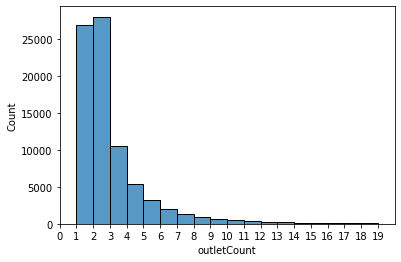

In [1230]:
sns.histplot(x="outletCount", data=twoThirty, bins=np.arange(0,20, 1))
plt.xlim(0, 20)
plt.xticks(np.arange(0, 20, 1))

In [1231]:
twoThirty_Two = twoThirty[twoThirty["outletCount"] >= 2]
print(f"percentage kept from twoThirty dataframe: {len(twoThirty_Two) / len(twoThirty)}") 

percentage kept from twoThirty dataframe: 0.6709236310359563


# apply day 1 coverage cutoff 

In [1335]:
fourtyPercent = twoThirty_Two[twoThirty_Two["dayOnePercent"] <= .40]
len(fourtyPercent) / len(twoThirty)

0.21835052805079055

proportion of stories kept after all three cutoffs 

In [1336]:
len(fourtyPercent) / len(clustDf)

0.09831505456144692

<Axes: xlabel='dayOnePercent', ylabel='Count'>

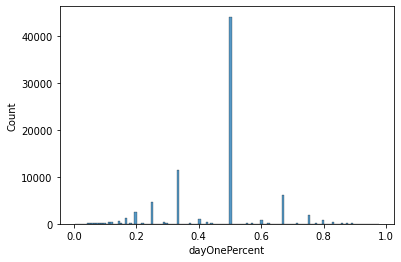

In [1337]:
sns.histplot(x="dayOnePercent", data=twoThirty)

<Axes: xlabel='dayOnePercent', ylabel='Proportion'>

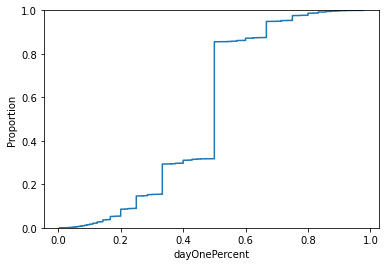

In [1338]:
#this occurs because we have tons of 2 (or more) day stories where half of the coverage is on each day 
sns.ecdfplot(x="dayOnePercent", data=twoThirty)

- ~36,317 stories >= 3 days and <= 20 days 
- 16,266 stories of those 36,317 have <= 40% of their coverage on day one 
- ~6,094 of our ~200000 stories last 3 or more days and have less than 10% of their coverage on day 1

In [1339]:
fourtyPercent["natPercent"] = fourtyPercent["national"].apply(np.mean)

<ipython-input-1339-529f112cfe3e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourtyPercent["natPercent"] = fourtyPercent["national"].apply(np.mean)


In [1340]:
#distribution of story types amongst non scoop stories 
nonScooped = twoThirty[twoThirty["dayOnePercent"] > .40]
nonScooped["national"] = nonScooped["national"].apply(np.mean)
print(f'mixed: {len(fourtyPercent[(fourtyPercent["natPercent"] != 0) & (fourtyPercent["natPercent"] != 1)]) / len(fourtyPercent)}')
print(f'local: {len(fourtyPercent[(fourtyPercent["natPercent"] == 0)]) / len(fourtyPercent)}')
print(f'national: {len(fourtyPercent[(fourtyPercent["natPercent"] == 1)]) / len(fourtyPercent)}')

mixed: 0.26738984567210916
local: 0.1161932453589801
national: 0.6164169089689108


<ipython-input-1340-b03a06eda635>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonScooped["national"] = nonScooped["national"].apply(np.mean)


## distribution of story types amongst "scoop stories"

In [1341]:
## How much of coverage is at all mixed 
print(f'mixed: {len(fourtyPercent[(fourtyPercent["natPercent"] != 0) & (fourtyPercent["natPercent"] != 1)]) / len(fourtyPercent)}')
print(f'local: {len(fourtyPercent[(fourtyPercent["natPercent"] == 0)]) / len(fourtyPercent)}')
print(f'national: {len(fourtyPercent[(fourtyPercent["natPercent"] == 1)]) / len(fourtyPercent)}')

mixed: 0.26738984567210916
local: 0.1161932453589801
national: 0.6164169089689108


<Axes: xlabel='natPercent', ylabel='Count'>

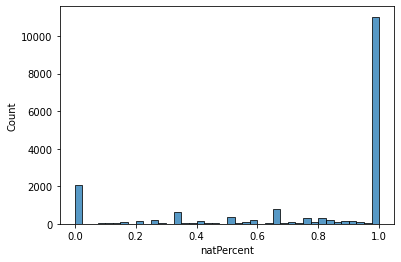

In [1342]:
sns.histplot(x="natPercent", data=fourtyPercent)

In [1343]:
def getStoryDay(inList): 
    dayOne = min(inList)
    return [((date - dayOne) / np.timedelta64(1, "D")) for date in inList]

fourtyPercent["storyDay"] = fourtyPercent["date"].apply(getStoryDay)

<ipython-input-1343-b5dd8b95e8d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourtyPercent["storyDay"] = fourtyPercent["date"].apply(getStoryDay)


In [1344]:
fourtyPercent["uniqueDays"] = fourtyPercent["date"].apply(lambda x: len(set(x)))

<ipython-input-1344-f7567157893b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourtyPercent["uniqueDays"] = fourtyPercent["date"].apply(lambda x: len(set(x)))


In [1345]:
#TEST
#fourtyPercent = fourtyPercent[fourtyPercent["uniqueDays"] >= 4]

In [1346]:
days = fourtyPercent.iloc[0, 3]
days = sorted(list(set(days)))
days[1]

Timestamp('2020-06-20 00:00:00')

In [1347]:
def getArticleIndex(inRow): 
    days = sorted(list(set(inRow["date"])))
    indexList = []
    
    #for each date, get which day of coverage it was in terms 
    #of articles published before it 
    for date in inRow["date"]: 
        indexList.append(days.index(date) / (inRow["uniqueDays"] -1))
    return indexList

fourtyPercent["storyPropCount"] = fourtyPercent.apply(getArticleIndex, axis=1)

<ipython-input-1347-873535bc37f3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourtyPercent["storyPropCount"] = fourtyPercent.apply(getArticleIndex, axis=1)


In [1348]:
fourtyLong = fourtyPercent.explode(["source", "key", "title", "date", "storyDay", "state", "storyPropCount", "national", "median_hh_inc", "rural_pct", "total_population", "articlesReported"])

RQ: what is the balance of local/national for scoops versus non scoops


In [1278]:
print(f'proportion of national in all coverage: {np.mean(df["national"] == True)}')
print(f'proportion of national in scooped coverage: {np.mean(fourtyLong["national"] == True)}')

proportion of national in all coverage: 0.6961397559566088
proportion of national in scooped coverage: 0.7696398958610794


In [1279]:
fourtyLong["storyPropDays"] = (fourtyLong["storyDay"]) / (fourtyLong["duration"] - 1) 

(array([26240.,  3365.,  7866.,  9109.,  2720., 20071.,  6676.,  3291.,
         2588., 34457.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

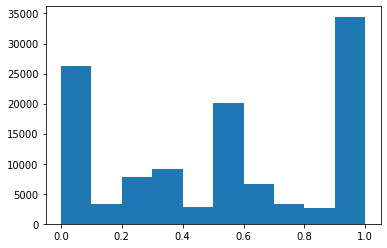

In [1280]:
plt.hist(fourtyLong["storyPropCount"])

In [1309]:
#now get the outlet level mean of stories in terms of when their stories appear in coverage 
coverageClusters = fourtyLong[["source", "storyPropDays","storyPropCount", "national", "articlesReported"]].groupby("source")\
.agg({"national":list, "articlesReported":list, "storyPropDays":[np.mean], "storyPropCount":[np.mean, len]}).droplevel([0], axis=1) #.sort_values(["mean", "len"], ascending=False)
coverageClusters.columns = ["national", "articlesReported", "storyPropDaysMean", "storyPropCountMean", "numStories"]
coverageClusters["national"] = coverageClusters["national"].apply(lambda x: x[0])
coverageClusters["articlesReported"] = coverageClusters["articlesReported"].apply(lambda x: x[0])

It looks like using days or number of articles is reasonable  for quantifying how far "through" coverage outlets are reporting

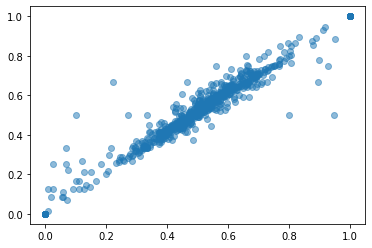

In [1310]:
plt.scatter(coverageClusters["storyPropDaysMean"], coverageClusters["storyPropCountMean"], alpha=.5)

get outlets that tend to be at the beginning of story clusters or at the end 

## do national or local outlets tend to be the first to report scoops? 

we will also want just the first story in story clusters from each outlet (below)

In [1312]:
#get the first day of coverage 
fourtyNoDups = fourtyLong.reset_index().sort_values(["clustNum", "date"]).drop_duplicates(subset=["clustNum", "source"])

firstCoverageClusters = fourtyNoDups[["source", "storyPropDays","storyPropCount", "national"]].groupby("source")\
.agg({"national":list, "storyPropDays":[np.mean], "storyPropCount":[np.mean, len]}).droplevel([0], axis=1) #.sort_values(["mean", "len"], ascending=False)
firstCoverageClusters.columns = ["national", "storyPropDaysMean", "storyPropCountMean", "numStories"]
firstCoverageClusters["national"] = firstCoverageClusters["national"].apply(lambda x: x[0])

#now get the outlet level mean of stories 
#firstCoverageClusters = fourtyNoDups[["source", "storyProportion"]].groupby("source").agg([np.mean, len]).droplevel([0], axis=1).sort_values(["mean", "len"], ascending=False)

In [1313]:
len(coverageClusters[coverageClusters["numStories"] > 10])

476

Text(0.5, 0.98, 'Distribution of When Outlets Report During the Life of a Story [0,1]')

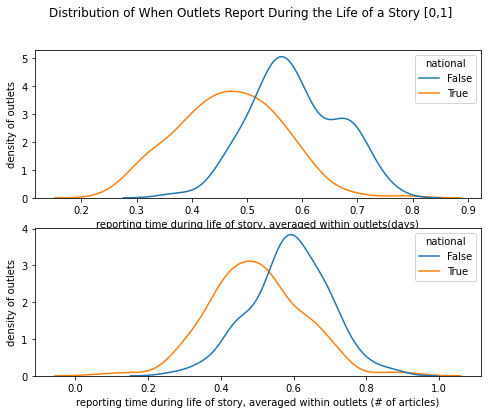

In [1314]:

fig, axs = plt.subplots(2, figsize=(8, 6))
sns.kdeplot(x="storyPropDaysMean", hue="national", common_norm=False, data=coverageClusters[coverageClusters["numStories"] > 100], ax=axs[0])
axs[0].set_xlabel("reporting time during life of story, averaged within outlets(days)")
axs[0].set_ylabel("density of outlets")

sns.kdeplot(x="storyPropCountMean", hue="national", common_norm=False, data=coverageClusters[coverageClusters["numStories"] > 10], ax=axs[1])
axs[1].set_xlabel("reporting time during life of story, averaged within outlets (# of articles)")
axs[1].set_ylabel("density of outlets")

fig.suptitle("Distribution of When Outlets Report During the Life of a Story [0,1]")

Text(0.5, 0.98, 'Distribution of When Stories are Reported [0,1]')

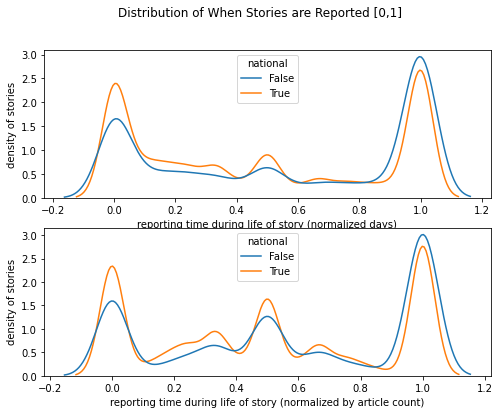

In [1315]:
fig, axs = plt.subplots(2, figsize=(8, 6))
sns.kdeplot(x="storyPropDays", hue="national", common_norm=False, data=fourtyLong, ax=axs[0])
axs[0].set_xlabel("reporting time during life of story (normalized days)")
axs[0].set_ylabel("density of stories")

sns.kdeplot(x="storyPropCount", hue="national", common_norm=False, data=fourtyLong, ax=axs[1])
axs[1].set_xlabel("reporting time during life of story (normalized by article count)")
axs[1].set_ylabel("density of stories")

fig.suptitle("Distribution of When Stories are Reported [0,1]")

## Same plots, but only consider first reporting

Text(0.5, 0.98, 'Distribution of When Outlets Report During the Life of a Story [0,1]')

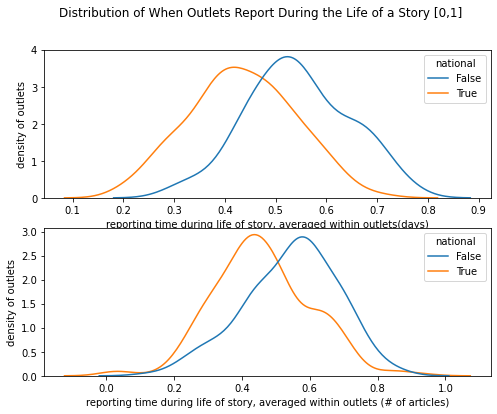

In [1316]:

fig, axs = plt.subplots(2, figsize=(8, 6))
sns.kdeplot(x="storyPropDaysMean", hue="national", common_norm=False, data=firstCoverageClusters[firstCoverageClusters["numStories"] > 100], ax=axs[0])
axs[0].set_xlabel("reporting time during life of story, averaged within outlets(days)")
axs[0].set_ylabel("density of outlets")

sns.kdeplot(x="storyPropCountMean", hue="national", common_norm=False, data=firstCoverageClusters[firstCoverageClusters["numStories"] > 10], ax=axs[1])
axs[1].set_xlabel("reporting time during life of story, averaged within outlets (# of articles)")
axs[1].set_ylabel("density of outlets")

fig.suptitle("Distribution of When Outlets Report During the Life of a Story [0,1]")

Text(0.5, 0.98, 'Distribution of When Stories are Reported [0,1]')

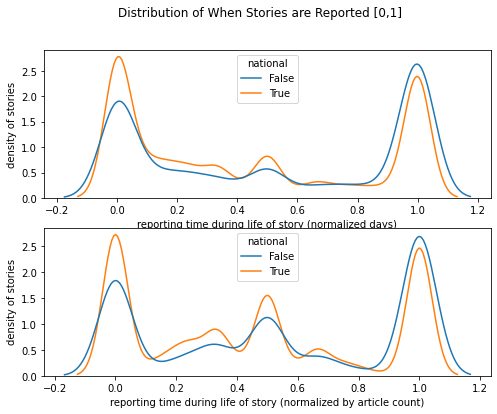

In [1317]:
fig, axs = plt.subplots(2, figsize=(8, 6))
sns.kdeplot(x="storyPropDays", hue="national", common_norm=False, data=fourtyNoDups, ax=axs[0])
axs[0].set_xlabel("reporting time during life of story (normalized days)")
axs[0].set_ylabel("density of stories")

sns.kdeplot(x="storyPropCount", hue="national", common_norm=False, data=fourtyNoDups, ax=axs[1])
axs[1].set_xlabel("reporting time during life of story (normalized by article count)")
axs[1].set_ylabel("density of stories")

fig.suptitle("Distribution of When Stories are Reported [0,1]")

let's get some examples of local and national early and late outlets 

In [1318]:
lenSorted = coverageClusters[coverageClusters["numStories"] > 100].sort_values(["storyPropCountMean", "storyPropDaysMean"])
lenSorted[lenSorted["national"] == False].head(5)

,national,articlesReported,storyPropDaysMean,storyPropCountMean,numStories
source,,,,,
theseattletimes,False,22736,0.373038,0.35229,1836
deseretnews,False,5011,0.442337,0.436611,169
therepublic,False,5053,0.46446,0.451335,384
theheraldnet,False,3954,0.461885,0.459505,146
startribune,False,4030,0.458385,0.47578,296


In [1319]:
lenSorted[lenSorted["national"] == False].tail(5)

,national,articlesReported,storyPropDaysMean,storyPropCountMean,numStories
source,,,,,
thebrainerddailydispatch,False,4666,0.719611,0.71637,282
theirontontribune,False,2353,0.686962,0.720999,133
thejamestownsun,False,3969,0.721366,0.73266,240
grandforksherald,False,4145,0.744008,0.748389,321
themitchelldailyrepublic,False,3900,0.75318,0.75299,208


In [1320]:
#let's get some stories from the mitchell daily republic

In [1321]:
fourtyLong = fourtyLong.reset_index()

In [1322]:
#mitchellClusts = list(set(fourtyLong.reset_index().loc[fourtyLong["source"] == "themitchelldailyrepublic", "clustNum"]))

In [1323]:
mitchellRows = fourtyLong[fourtyLong["clustNum"].isin(mitchellClusts)]
mitchellClusts[:5]

[520.0, 20488.0, 78344.0, 13835.0, 159754.0]

In [1324]:
fourtyNoDups.loc[fourtyLong["source"] == "themitchelldailyrepublic", ["clustNum", "source", "date", "title", "clustSize", "duration", "dayOnePercent", "duration", "uniqueDays", "storyPropDays"]].sort_values("uniqueDays", ascending=False)

,clustNum,source,date,title,clustSize,duration,dayOnePercent,duration,uniqueDays,storyPropDays
24038,22282.0,themitchelldailyrepublic,2020-07-15,High-profile Twitter accounts swept up in wave...,245,24.0,0.102041,24.0,19,0.0
22979,21620.0,themitchelldailyrepublic,2020-12-13,"Sources say, suspected Russian hackers spied o...",529,22.0,0.011342,22.0,17,0.238095
21891,20488.0,themitchelldailyrepublic,2020-08-02,Wild's Dumba kneels during anthem,36,30.0,0.027778,30.0,10,0.103448
54976,59730.0,themitchelldailyrepublic,2020-12-23,Second Black man shot dead by police in Ohio c...,112,10.0,0.008929,10.0,9,0.111111
20830,19080.0,themitchelldailyrepublic,2020-10-07,Women creators of genetic 'scissors' win Nobel...,59,26.0,0.016949,26.0,8,0.2
...,...,...,...,...,...,...,...,...,...,...
52464,56534.0,themitchelldailyrepublic,2020-11-29,High school sailing team navigates uncertain w...,16,8.0,0.125000,8.0,2,1.0
52446,56530.0,themitchelldailyrepublic,2020-08-29,Four young entrepreneurs Kickstart their 'dogh...,7,8.0,0.142857,8.0,2,1.0
50677,53530.0,themitchelldailyrepublic,2020-07-27,Rising pregnancy complications coincide with r...,7,2.0,0.142857,2.0,2,1.0
50205,52755.0,themitchelldailyrepublic,2020-08-21,A little fishing tackle goes a long way after ...,7,8.0,0.142857,8.0,2,1.0


In [1325]:


lenSorted[lenSorted["national"] == True].head(5)

lenSorted[lenSorted["national"] == True].tail(5)

,national,articlesReported,storyPropDaysMean,storyPropCountMean,numStories
source,,,,,
needtoknow,True,874,0.633118,0.686932,133
sgtreport,True,5129,0.639538,0.698879,529
stillnessinthestorm,True,3832,0.694819,0.723604,448
principiascientificinternational,True,1098,0.671632,0.723981,134
prepareforchange,True,1532,0.784196,0.819845,103


In [1326]:
veracityDf = pd.read_csv("/shared/3/projects/newsDiffusion/data/raw/NELA-gt-2020/labels.csv")
veracityDf["label"] = 2 - veracityDf["label"]
veracityDf.columns = ["source", "veracityScore"]


In [1327]:
coverageClusters = pd.merge(coverageClusters.reset_index(), veracityDf, on="source", how="left")

In [1331]:
fourtyLong = pd.merge(fourtyLong.reset_index(), veracityDf, on="source", how="left")

In [1332]:
#and remake the firstCoverageClusters dataframe to include the veracity labels 
fourtyNoDups = fourtyLong.sort_values(["clustNum", "date"]).drop_duplicates(subset=["clustNum", "source"])

firstCoverageClusters = fourtyNoDups[["source", "storyPropDays","storyPropCount", "national", "veracityScore"]].groupby("source")\
.agg({"national":list, "veracityScore":list, "storyPropDays":[np.mean], "storyPropCount":[np.mean, len]}).droplevel([0], axis=1) #.sort_values(["mean", "len"], ascending=False)
firstCoverageClusters.columns = ["national", "veracityScore", "storyPropDaysMean", "storyPropCountMean", "numStories"]
firstCoverageClusters["national"] = firstCoverageClusters["national"].apply(lambda x: x[0])
firstCoverageClusters["veracityScore"] = firstCoverageClusters["veracityScore"].apply(lambda x: x[0])

KeyError: "['veracityScore'] not in index"

In [ ]:
fig, axs = plt.subplots(2, figsize=(8, 6))
sns.kdeplot(x="storyPropDaysMean", hue="veracityScore", common_norm=False, data=coverageClusters[coverageClusters["numStories"] > 100], ax=axs[0])
axs[0].set_xlabel("reporting time during life of story, averaged within outlets(days)")
axs[0].set_ylabel("density of outlets")

sns.kdeplot(x="storyPropCountMean", hue="veracityScore", common_norm=False, data=coverageClusters[coverageClusters["numStories"] > 10], ax=axs[1])
axs[1].set_xlabel("reporting time during life of story, averaged within outlets (# of articles)")
axs[1].set_ylabel("density of outlets")

fig.suptitle("Distribution of When Outlets Report During the Life of a Story [0,1]")

In [ ]:
fig, axs = plt.subplots(2, figsize=(8, 6))
sns.kdeplot(x="storyPropDays", hue="veracityScore", common_norm=False, data=fourtyLong, ax=axs[0])
axs[0].set_xlabel("reporting time during life of story (normalized days)")
axs[0].set_ylabel("density of stories")

sns.kdeplot(x="storyPropCount", hue="veracityScore", common_norm=False, data=fourtyLong, ax=axs[1])
axs[1].set_xlabel("reporting time during life of story (normalized by article count)")
axs[1].set_ylabel("density of stories")

fig.suptitle("Distribution of When Stories are Reported [0,1]")

In [ ]:
fig, axs = plt.subplots(2, figsize=(8, 6))
sns.kdeplot(x="storyPropDaysMean", hue="veracityScore", common_norm=False, data=firstCoverageClusters[firstCoverageClusters["numStories"] > 100], ax=axs[0])
axs[0].set_xlabel("reporting time during life of story, averaged within outlets(days)")
axs[0].set_ylabel("density of outlets")

sns.kdeplot(x="storyPropCountMean", hue="veracityScore", common_norm=False, data=firstCoverageClusters[firstCoverageClusters["numStories"] > 10], ax=axs[1])
axs[1].set_xlabel("reporting time during life of story, averaged within outlets (# of articles)")
axs[1].set_ylabel("density of outlets")

fig.suptitle("Distribution of When Outlets Report During the Life of a Story [0,1]")

In [ ]:
fig, axs = plt.subplots(2, figsize=(8, 6))
sns.kdeplot(x="storyPropDays", hue="veracityScore", common_norm=False, data=fourtyNoDups, ax=axs[0])
axs[0].set_xlabel("reporting time during life of story (normalized days)")
axs[0].set_ylabel("density of stories")

sns.kdeplot(x="storyPropCount", hue="veracityScore", common_norm=False, data=fourtyNoDups, ax=axs[1])
axs[1].set_xlabel("reporting time during life of story (normalized by article count)")
axs[1].set_ylabel("density of stories")

fig.suptitle("Distribution of When Stories are Reported [0,1]")

array([[ 1.        , -0.13540109],
       [-0.13540109,  1.        ]])

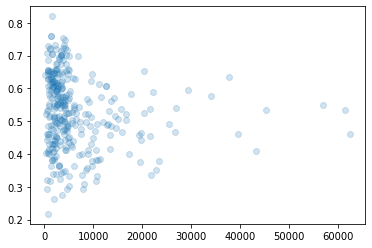

In [1362]:
test = coverageClusters[coverageClusters["numStories"] > 50]
plt.scatter(test["articlesReported"], test["storyPropCountMean"], alpha=.2)
np.corrcoef(list(test["articlesReported"]), list(test["storyPropCountMean"]))

In [ ]:
fig, axs = plt.subplots(2, figsize=(8, 6))
sns.kdeplot(x="storyPropDaysMean", hue="veracityScore", common_norm=False, data=coverageClusters[coverageClusters["numStories"] > 100], ax=axs[0])
axs[0].set_xlabel("reporting time during life of story, averaged within outlets(days)")
axs[0].set_ylabel("density of outlets")

sns.kdeplot(x="storyPropCountMean", hue="veracityScore", common_norm=False, data=coverageClusters[coverageClusters["numStories"] > 10], ax=axs[1])
axs[1].set_xlabel("reporting time during life of story, averaged within outlets (# of articles)")
axs[1].set_ylabel("density of outlets")

fig.suptitle("Distribution of When Outlets Report During the Life of a Story [0,1]")

do certain states report first? 

In [1177]:
#get only the local articles 
stateReportTimes = fourtyLong.loc[fourtyLong["national"] == False, ["state", "storyPropCount", "storyPropDays"]].groupby("state").agg([np.mean, len]).droplevel([0], axis=1)
stateReportTimes.columns = ["storyPropCountMean", "len", "storyPropDaysMean", "lenDup"]
stateReportTimes[stateReportTimes["len"] > 40].sort_values("storyPropDaysMean", ascending=False).drop(columns=["len"])
#.sort_values("storyPropCount")

,storyPropCountMean,storyPropDaysMean,lenDup
state,,,
Tennessee,0.692143,0.715493,50
North Dakota,0.714584,0.705799,865
Hawaii,0.699961,0.677786,446
South Dakota,0.662202,0.659862,348
Wisconsin,0.672135,0.6584,161
Minnesota,0.632692,0.62743,2826
Alabama,0.632806,0.623684,161
Missouri,0.63503,0.614781,1300
Pennsylvania,0.611398,0.605764,1700


In [1171]:
fourtyLong[fourtyLong["state"] == "North Dakota"]

,index,clustNum,source,key,title,date,state,national,median_hh_inc,rural_pct,...,clustSize,duration,dayOnePercent,outletCount,natPercent,storyDay,uniqueDays,storyPropCount,storyPropDays,veracityScore
201,201,154.0,theforum,100847,"Minnesota National Guard, Air Force plan secon...",2020-05-11,North Dakota,False,54926.0,10.434777,...,14,9.0,0.071429,10,0.000000,7.0,4,0.666667,0.875,NaN
202,202,154.0,grandforksherald,100852,"Minnesota National Guard, Air Force plan secon...",2020-05-11,North Dakota,False,50652.0,16.769118,...,14,9.0,0.071429,10,0.000000,7.0,4,0.666667,0.875,NaN
403,403,416.0,theforum,323865,Koepka makes solid start in bid for PGA Champi...,2020-08-07,North Dakota,False,54926.0,10.434777,...,18,7.0,0.333333,13,0.277778,4.0,4,0.666667,0.666667,NaN
404,404,416.0,grandforksherald,323873,Koepka makes solid start in bid for PGA Champi...,2020-08-07,North Dakota,False,50652.0,16.769118,...,18,7.0,0.333333,13,0.277778,4.0,4,0.666667,0.666667,NaN
449,449,520.0,theforum,285628,Vikings finalizing multi-year contract extensi...,2020-07-22,North Dakota,False,54926.0,10.434777,...,21,5.0,0.380952,13,0.095238,0.0,5,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114410,114260,194951.0,grandforksherald,24256,Hauser: Is your soul weary?,2020-04-13,North Dakota,False,50652.0,16.769118,...,4,2.0,0.250000,4,0.000000,1.0,2,1.0,1.0,NaN
115659,115509,202643.0,devilslakedailyjournal,65723,White House unveils blueprint to expand state ...,2020-04-28,North Dakota,False,50776.0,34.992577,...,24,2.0,0.041667,23,0.083333,1.0,2,1.0,1.0,NaN
116310,116159,207408.0,theforum,549399,Morken: Patience pays off while bow hunting deer,2020-11-10,North Dakota,False,54926.0,10.434777,...,16,5.0,0.062500,15,0.000000,4.0,2,1.0,1.0,NaN
116311,116160,207408.0,grandforksherald,549405,Morken: Patience pays off while bow hunting deer,2020-11-10,North Dakota,False,50652.0,16.769118,...,16,5.0,0.062500,15,0.000000,4.0,2,1.0,1.0,NaN


In [538]:
myList = ["a, b, c"]
indList = [0]
myList

AttributeError: 'list' object has no attribute 'values'

In [539]:
def getMeanCoverage(inSer): 
    storyProps = inSer["storyProportion"]
    rel = [storyProps[i] for i in range(0, len(inSer["label"])) if inSer["label"][i] == 0] 
    mixed = [storyProps[i] for i in range(0, len(inSer["label"])) if inSer["label"][i] == 1]
    unrel = [storyProps[i] for i in range(0, len(inSer["label"])) if inSer["label"][i] == 2]
    """
    relMean = np.nan
    if len(relInds) > 0: 
        relMean = np.mean(inSer["storyProportion"][relInds])
        
    mixedMean = np.nan
    if len(mixedInds) > 0: 
        print(mixedInds)
        print(inSer["storyProportion"])
        mixedMean = np.mean(inSer["storyProportion"][mixedInds])
    
    unrelMean = np.nan
    if len(unrelInds) > 0: 
        unrelMean = np.mean(inSer["storyProportion"][unrelInds])
    """
    
    return (np.mean(rel), np.mean(mixed), np.mean(unrel)) 

veracityDiff[["relMean", "mixedMean", "unrelMean"]] = list(veracityDiff.apply(getMeanCoverage, axis=1))

/opt/anaconda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [541]:
#now get diffs for for rel and unrel 
relUnrel = veracityDiff.dropna(subset=["relMean", "unrelMean"])
relUnrel["relUnrelDiff"] = relUnrel["relMean"] - relUnrel["unrelMean"]

<ipython-input-541-cec816e33f90>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relUnrel["relUnrelDiff"] = relUnrel["relMean"] - relUnrel["unrelMean"]


In [557]:
relUnrel["clustSize"]

clustNum
8.0         10
24.0         7
79.0        28
95.0        14
110.0       31
            ..
208587.0     4
208813.0    12
208819.0     4
209116.0     3
209248.0     5
Name: clustSize, Length: 6488, dtype: int64

<ipython-input-558-a6b33ccdcafa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relUnrel["clustSize"] = relUnrel["label"].apply(len)


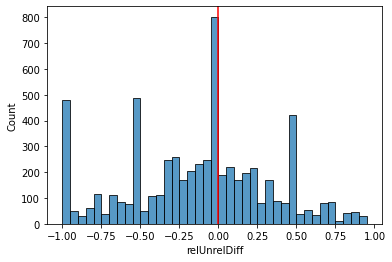

In [558]:
len(relUnrel[relUnrel["relUnrelDiff"] > 0]) / len(relUnrel)
relUnrel["clustSize"] = relUnrel["label"].apply(len)
sns.histplot(x="relUnrelDiff", data=relUnrel, bins=np.arange(-1, 1, .05))
plt.axvline(0, color="red")

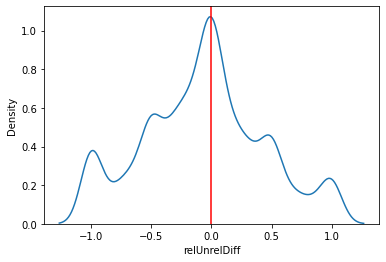

In [546]:
sns.kdeplot(x="relUnrelDiff", data=relUnrel[relUnrel["clustSize"] > 0])
plt.axvline(0, color="red")

Text(0.5, 0, 'reliable coverage day - unreliable coverage day')

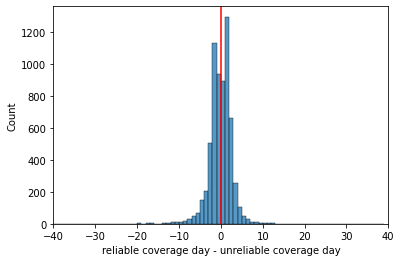

In [520]:
sns.histplot(x="relUnrelDiff", data=relUnrel[relUnrel["clustSize"] > 0], bins=np.arange(-40, 40, 1))
plt.axvline(0, color="red")
plt.xlim(-40, 40)
plt.xlabel("reliable coverage day - unreliable coverage day")

In [517]:
veracityDiff["meanProportion"] = veracityDiff["storyProportion"].apply(np.mean)
#veracityDiff.pivot(columns=["label", "clustNum"], values=["meanProportion"])

In [431]:
#we now want to do the same analysis but within story clusters, and for local news  
#fourtyPercent.reset_index()

In [1016]:
fourtyLong[]

,index,clustNum,source,key,title,date,national,median_hh_inc,rural_pct,total_population,clustSize,duration,dayOnePercent,outletCount,natPercent,storyDay,uniqueDays,storyPropCount,storyPropDays,veracityScore
0,0,23.0,lewrockwell,1446596,Head of the Vaccine Hydra: The Rise of Robert ...,2020-05-19,True,NaN,NaN,NaN,6,6.0,0.166667,4,1.0,5.0,4,1.0,1.0,0.0
1,1,23.0,freedom-bunker,1451494,Head of the Vaccine Hydra: The Rise of Robert ...,2020-05-19,True,NaN,NaN,NaN,6,6.0,0.166667,4,1.0,5.0,4,1.0,1.0,NaN
2,2,23.0,mintpressnews,1591484,Head of the Hydra: The Rise of Robert Kadlec,2020-05-15,True,NaN,NaN,NaN,6,6.0,0.166667,4,1.0,1.0,4,0.333333,0.2,0.0
3,3,23.0,therussophileorg,2095707,"Head of the Hydra: the Rise of Robert Kadlec, ...",2020-05-14,True,NaN,NaN,NaN,6,6.0,0.166667,4,1.0,0.0,4,0.0,0.0,NaN
4,4,23.0,therussophileorg,2096002,The Head of the Hydra: Rise of Robert Kadlec,2020-05-18,True,NaN,NaN,NaN,6,6.0,0.166667,4,1.0,4.0,4,0.666667,0.8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61153,61051,208813.0,pinknewsuk,2822767,Chicago’s Black lesbian mayor has one thing to...,2020-05-31,True,NaN,NaN,NaN,15,13.0,0.133333,12,1.0,2.0,5,0.5,0.166667,2.0
61154,61052,208813.0,thepoliticalinsider,2828392,Chicago Mayor Lori Lightfoot Sends Brutal Mess...,2020-05-30,True,NaN,NaN,NaN,15,13.0,0.133333,12,1.0,1.0,5,0.25,0.083333,1.0
61155,61053,208813.0,foxnews,2867129,Chicago mayor tells Trump 'F-U' after tweet ab...,2020-05-30,True,NaN,NaN,NaN,15,13.0,0.133333,12,1.0,1.0,5,0.25,0.083333,0.0
61156,61054,208813.0,thelibertydaily,3010592,Communist Chicago Mayor Lori Lightfoot Says Sh...,2020-05-30,True,NaN,NaN,NaN,15,13.0,0.133333,12,1.0,1.0,5,0.25,0.083333,0.0
